<h1>The Multi-layered Perceptron Neural Collaborative Filtering (MLP-NCF) proposed model training</h1>

<h2>Import necessary python library for model training</h2>

In [1]:
import zipfile
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import requests
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import time
import argparse
import matplotlib.pyplot as plt

<h2>The data preparation for training class</h2>

In [2]:
class MovieLens(Dataset):
    def __init__(self, df: pd.DataFrame, total_df: pd.DataFrame, ng_ratio:int)->None:
        '''
        : param df: training dataframe
        : param total_df: the entire dataframe
        : param ng_ratio: negative sampling ratio
        '''
        super(MovieLens, self).__init__()

        self.df = df
        self.total_df = total_df
        self.ng_ratio = ng_ratio
        self.users, self.items, self.labels = self._negative_sampling()

    def __len__(self) -> int:
        '''
        get length of data
        : return: len(data)
        '''
        return len(self.users)

    def __getitem__(self, index):
        '''
        transform userId[index], item[index] to Tensor and return to Datalaoder object.
        : param index: index for dataset.
        : return: user, item, rating
        '''
        return self.users[index], self.items[index], self.labels[index]

    def _negative_sampling(self) :
        '''
        sampling one positive feedback per #(ng ratio) negative feedback
        : return: list of users, list of items, list of targets
        '''
        df = self.df
        total_df = self.total_df
        users, items, labels = [], [], []
        user_item_set = set(zip(df['userId'], df['movieId']))
        total_user_item_set = set(zip(total_df['userId'],total_df['movieId']))
        all_movieIds = total_df['movieId'].unique()
        
        # negative feedback dataset ratio
        negative_ratio = self.ng_ratio
        for u, i in user_item_set:
            # positive instance
            users.append(u)
            items.append(i)
            labels.append(1.0)

            #visited check
            visited=[]
            visited.append(i)
            
            # negative instance
            for i in range(negative_ratio):
                # first item random choice
                negative_item = np.random.choice(all_movieIds)
 
                # check if item and user has interaction, if true then set new value from random
                while (u, negative_item) in total_user_item_set or negative_item in visited :
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                visited.append(negative_item)
                labels.append(0.0)
        print(f"negative sampled data: {len(labels)}")
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

<h2>The Multi-layered perceptron neural collaborative filtering (NCF) model</h2>

In [3]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, layer_dims, use_NeuMF=False):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        
        # Calculate input dimension for first layer
        first_layer_input = embedding_size * 2  # Concatenated user and item embeddings
        
        # Build MLP layers dynamically
        layers = []
        input_dim = first_layer_input
        for output_dim in layer_dims:
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.ReLU())
            input_dim = output_dim
        
        self.mlp_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(layer_dims[-1], 1)
        self.sigmoid = nn.Sigmoid()
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.mlp_layers(x)
        x = self.output_layer(x)
        return self.sigmoid(x).view(-1)

<h2>Evaluation Metrics</h2>

In [4]:
def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0

def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item)
		return np.reciprocal(np.log2(index+2))
	return 0

def metrics(model, data_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in data_loader:

		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)

		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		gt_item = item[0].item()
		HR.append(hit(gt_item, recommends))
		NDCG.append(ndcg(gt_item, recommends))

	return np.mean(HR), np.mean(NDCG)

<h2>Model training class</h2>

In [5]:
class Train():
    def __init__(self, model: torch.nn.Module,
                 optimizer: torch.optim,
                 epochs: int,
                 dataloader: torch.utils.data.dataloader,
                 criterion: torch.nn,
                 test_obj: torch.utils.data.dataloader,
                 device: str = 'cuda',
                 print_cost: bool = True,
                 top_k: int = 10):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.criterion = criterion
        self.device = device
        self.print_cost = print_cost
        self.test = test_obj
        self.top_k = top_k

    def train(self):
        model = self.model
        optimizer = self.optimizer
        total_epochs = self.epochs
        dataloader = self.dataloader
        criterion = self.criterion
        total_batch = len(dataloader)
        loss = []
        device = self.device
        test_dataloader = self.test

        hr_list = []
        ndcg_list = []
        test_loss_list = []

        for epoch in range(0, total_epochs):
            epoch_loss = 0
            with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{total_epochs}', unit='batch') as pbar:
                for user, item, target in dataloader:
                    user, item, target = user.to(device), item.to(device), target.float().to(device)
                    optimizer.zero_grad()
                    pred = model(user, item)
                    cost = criterion(pred, target)
                    cost.backward()
                    optimizer.step()
                    epoch_loss += cost.item()
                    pbar.update(1)
                    pbar.set_postfix({'loss': cost.item()})

            avg_epoch_loss = epoch_loss / total_batch
            loss.append(avg_epoch_loss)

            if self.print_cost:
                HR, NDCG = metrics(model, self.test, self.top_k, device)

                model.eval()
                test_loss = 0
                with torch.no_grad():
                    for user, item, target in test_dataloader:
                        user, item, target = user.to(device), item.to(device), target.float().to(device)
                        pred = model(user, item)
                        cost = criterion(pred, target)
                        test_loss += cost.item()
                avg_test_loss = test_loss / len(test_dataloader)
                model.train()

                print(
                    "Epochs: {}\tAvg Train Loss: {:.4f}\tAvg Test Loss: {:.4f}\tHR: {:.3f}\tNDCG: {:.3f}".format(
                        epoch+1, avg_epoch_loss, avg_test_loss, np.mean(HR), np.mean(NDCG)))

                hr_list.append(np.mean(HR))
                ndcg_list.append(np.mean(NDCG))
                test_loss_list.append(avg_test_loss)

        if self.print_cost:
            print('Learning finished')
        return loss, test_loss_list, hr_list, ndcg_list

In [6]:
def plot_comparison_metrics(train_loss_1, test_loss_list_1, hr_list_1, ndcg_list_1,
                           train_loss_4, test_loss_list_4, hr_list_4, ndcg_list_4, top_k):
    epochs = np.arange(1, len(train_loss_1) + 1)

    output_dir = './Training Results/'
    os.makedirs(output_dir, exist_ok=True)

    # Create a single figure with 4 subplots
    plt.figure(figsize=(16, 12))
    
    # Plot Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_1, label='Dataset 1', marker='o')
    plt.plot(epochs, train_loss_4, label='Dataset 2', marker='x')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Test Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, test_loss_list_1, label='Dataset 1', marker='o')
    plt.plot(epochs, test_loss_list_4, label='Dataset 2', marker='x')
    plt.title('Test Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot HR@10
    plt.subplot(2, 2, 3)
    plt.plot(epochs, hr_list_1, label='Dataset 1', marker='o')
    plt.plot(epochs, hr_list_4, label='Dataset 2', marker='x')
    plt.title(f'Hit Ratio @ {top_k} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot NDCG@10
    plt.subplot(2, 2, 4)
    plt.plot(epochs, ndcg_list_1, label='Dataset 1', marker='o')
    plt.plot(epochs, ndcg_list_4, label='Dataset 2', marker='x')
    plt.title(f'NDCG @ {top_k} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add main title and adjust layout
    plt.suptitle('Model 1 Performance Comparison on Dataset 1 and Dataset 2', fontsize=16, y=1.02)
    plt.tight_layout()
    
    # Save the entire figure
    plt.savefig(os.path.join(output_dir, f'ncf_performance_comparison_top_{top_k}_D1D2_M1.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

<h2>Putting everything together</h2>

In [7]:
import pandas as pd
import torch
import argparse
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import time

start_time = time.time()  # Record start time

# check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# print GPU information
if torch.cuda.is_available():
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())

# directory to save checkpoints
pretrain_dir = 'ncf_models'
if not os.path.isdir(pretrain_dir):
    os.makedirs(pretrain_dir)

# the train, test and total dataset
train_df_1 = pd.read_csv("./Datasets/train_D1.csv")
test_df_1 = pd.read_csv("./Datasets/test_D1.csv")
total_df_1 = pd.read_csv("./Datasets/ratings_preprocessed_D1.csv")

train_df_4 = pd.read_csv("./Datasets/train_D2.csv")
test_df_4 = pd.read_csv("./Datasets/test_D2.csv")
total_df_4 = pd.read_csv("./Datasets/ratings_preprocessed_D2.csv")

# make torch.utils.data.Data object
train_set_1 = MovieLens(df=train_df_1, total_df=total_df_1, ng_ratio=3)
test_set_1 = MovieLens(df=test_df_1, total_df=total_df_1, ng_ratio=99)
train_set_4 = MovieLens(df=train_df_4, total_df=total_df_4, ng_ratio=3)
test_set_4 = MovieLens(df=test_df_4, total_df=total_df_4, ng_ratio=99)

# Find Global Maximums
max_num_users_global = max(total_df_1['userId'].max(), total_df_4['userId'].max()) + 1  #, total_df_2['userId'].max()
max_num_items_global = max(total_df_1['movieId'].max(), total_df_4['movieId'].max()) + 1  #, total_df_2['movieId'].max()

print('data loaded!')

# dataloader for train_dataset
dataloader_train_1 = DataLoader(dataset=train_set_1, batch_size=256, shuffle=True, num_workers=0)

# dataloader for test_dataset
dataloader_test_1 = DataLoader(dataset=test_set_1, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

# dataloader for train_dataset
dataloader_train_4 = DataLoader(dataset=train_set_4, batch_size=256, shuffle=True, num_workers=0)

# dataloader for test_dataset
dataloader_test_4 = DataLoader(dataset=test_set_4, batch_size=100, shuffle=False, num_workers=0, drop_last=True)

model = MLP(num_users=max_num_users_global, num_items=max_num_items_global, embedding_size=32, layer_dims=[64,32,16], use_NeuMF=False) #emb size, layer

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #learning rate

# objective function is log loss (Cross-entropy loss)
criterion = torch.nn.BCELoss()

model.to(device)
save_model = True

end_time = time.time()    # Record end time
training_time = end_time - start_time  # Calculate training time
print(f"Training time: {training_time:.5f}")  # Print the training time

device: cpu
negative sampled data: 400684
negative sampled data: 61000
negative sampled data: 3976676
negative sampled data: 604000
data loaded!
Training time: 118.99995


<h2>Dataset 1 Model Training</h2>

In [9]:
# Initialize trainer with customizable top_k

trainer_1 = Train(model=model,
              optimizer=optimizer,
              criterion=criterion,
              epochs=15,
              test_obj=dataloader_test_1,
              dataloader=dataloader_train_1,
              device=device,
              print_cost=True,
              top_k=10)
    
# measuring time
start = time.time()
loss_1, test_loss_list_1, hr_list_1, ndcg_list_1 = trainer_1.train()

end = time.time()

time_message = f'Training time: {end-start:.5f} seconds'
print(time_message)

Epoch 1/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:24<00:00, 18.50batch/s, loss=0.439]


Epochs: 1	Avg Train Loss: 0.3974	Avg Test Loss: 0.1823	HR: 0.590	NDCG: 0.325


Epoch 2/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:27<00:00, 17.87batch/s, loss=0.215]


Epochs: 2	Avg Train Loss: 0.3222	Avg Test Loss: 0.1887	HR: 0.613	NDCG: 0.354


Epoch 3/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:27<00:00, 17.90batch/s, loss=0.136]


Epochs: 3	Avg Train Loss: 0.2779	Avg Test Loss: 0.1858	HR: 0.608	NDCG: 0.356


Epoch 4/15: 100%|████████████████████████████████████████████████████| 1566/1566 [01:31<00:00, 17.16batch/s, loss=0.31]


Epochs: 4	Avg Train Loss: 0.2430	Avg Test Loss: 0.1915	HR: 0.644	NDCG: 0.369


Epoch 5/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:29<00:00, 17.48batch/s, loss=0.262]


Epochs: 5	Avg Train Loss: 0.2188	Avg Test Loss: 0.1880	HR: 0.631	NDCG: 0.366


Epoch 6/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:36<00:00, 16.15batch/s, loss=0.187]


Epochs: 6	Avg Train Loss: 0.2010	Avg Test Loss: 0.2106	HR: 0.631	NDCG: 0.366


Epoch 7/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:34<00:00, 16.60batch/s, loss=0.158]


Epochs: 7	Avg Train Loss: 0.1864	Avg Test Loss: 0.2515	HR: 0.628	NDCG: 0.369


Epoch 8/15: 100%|████████████████████████████████████████████████████| 1566/1566 [01:33<00:00, 16.78batch/s, loss=0.22]


Epochs: 8	Avg Train Loss: 0.1747	Avg Test Loss: 0.2246	HR: 0.625	NDCG: 0.360


Epoch 9/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:32<00:00, 16.95batch/s, loss=0.269]


Epochs: 9	Avg Train Loss: 0.1656	Avg Test Loss: 0.2103	HR: 0.621	NDCG: 0.362


Epoch 10/15: 100%|███████████████████████████████████████████████████| 1566/1566 [01:32<00:00, 16.93batch/s, loss=0.18]


Epochs: 10	Avg Train Loss: 0.1570	Avg Test Loss: 0.2545	HR: 0.626	NDCG: 0.356


Epoch 11/15: 100%|██████████████████████████████████████████████████| 1566/1566 [01:32<00:00, 16.96batch/s, loss=0.105]


Epochs: 11	Avg Train Loss: 0.1493	Avg Test Loss: 0.2740	HR: 0.628	NDCG: 0.353


Epoch 12/15: 100%|██████████████████████████████████████████████████| 1566/1566 [01:35<00:00, 16.46batch/s, loss=0.148]


Epochs: 12	Avg Train Loss: 0.1427	Avg Test Loss: 0.2788	HR: 0.621	NDCG: 0.351


Epoch 13/15: 100%|██████████████████████████████████████████████████| 1566/1566 [01:27<00:00, 17.82batch/s, loss=0.181]


Epochs: 13	Avg Train Loss: 0.1364	Avg Test Loss: 0.2704	HR: 0.621	NDCG: 0.352


Epoch 14/15: 100%|██████████████████████████████████████████████████| 1566/1566 [01:31<00:00, 17.20batch/s, loss=0.129]


Epochs: 14	Avg Train Loss: 0.1310	Avg Test Loss: 0.2750	HR: 0.626	NDCG: 0.348


Epoch 15/15: 100%|█████████████████████████████████████████████████| 1566/1566 [01:30<00:00, 17.30batch/s, loss=0.0595]


Epochs: 15	Avg Train Loss: 0.1254	Avg Test Loss: 0.2790	HR: 0.631	NDCG: 0.355
Learning finished
Training time: 1422.54342 seconds


<h2>Dataset 4 Model Training</h2>

In [8]:
# Initialize trainer with customizable top_k

trainer_2 = Train(model=model,
              optimizer=optimizer,
              criterion=criterion,
              epochs=15,
              test_obj=dataloader_test_4,
              dataloader=dataloader_train_4,
              device=device,
              print_cost=True,
              top_k=10)
    
# measuring time
start = time.time()
loss_4, test_loss_list_4, hr_list_4, ndcg_list_4 = trainer_2.train()

end = time.time()

time_message = f'Training time: {end-start:.5f} seconds'
print(time_message)

Epoch 1/15: 100%|█████████████████████████████████████████████████| 15534/15534 [14:22<00:00, 18.00batch/s, loss=0.386]


Epochs: 1	Avg Train Loss: 0.3845	Avg Test Loss: 0.2273	HR: 0.524	NDCG: 0.290


Epoch 2/15: 100%|██████████████████████████████████████████████████| 15534/15534 [14:47<00:00, 17.51batch/s, loss=0.36]


Epochs: 2	Avg Train Loss: 0.3362	Avg Test Loss: 0.2001	HR: 0.579	NDCG: 0.329


Epoch 3/15: 100%|█████████████████████████████████████████████████| 15534/15534 [14:17<00:00, 18.11batch/s, loss=0.328]


Epochs: 3	Avg Train Loss: 0.3124	Avg Test Loss: 0.1943	HR: 0.615	NDCG: 0.347


Epoch 4/15: 100%|█████████████████████████████████████████████████| 15534/15534 [14:21<00:00, 18.03batch/s, loss=0.348]


Epochs: 4	Avg Train Loss: 0.2998	Avg Test Loss: 0.1890	HR: 0.628	NDCG: 0.360


Epoch 5/15: 100%|█████████████████████████████████████████████████| 15534/15534 [14:41<00:00, 17.61batch/s, loss=0.309]


Epochs: 5	Avg Train Loss: 0.2913	Avg Test Loss: 0.1885	HR: 0.632	NDCG: 0.362


Epoch 6/15: 100%|█████████████████████████████████████████████████| 15534/15534 [14:54<00:00, 17.37batch/s, loss=0.307]


Epochs: 6	Avg Train Loss: 0.2844	Avg Test Loss: 0.1619	HR: 0.642	NDCG: 0.370


Epoch 7/15: 100%|█████████████████████████████████████████████████| 15534/15534 [16:41<00:00, 15.51batch/s, loss=0.284]


Epochs: 7	Avg Train Loss: 0.2787	Avg Test Loss: 0.1497	HR: 0.643	NDCG: 0.373


Epoch 8/15: 100%|█████████████████████████████████████████████████| 15534/15534 [16:01<00:00, 16.16batch/s, loss=0.274]


Epochs: 8	Avg Train Loss: 0.2739	Avg Test Loss: 0.1815	HR: 0.642	NDCG: 0.374


Epoch 9/15: 100%|█████████████████████████████████████████████████| 15534/15534 [14:55<00:00, 17.34batch/s, loss=0.258]


Epochs: 9	Avg Train Loss: 0.2695	Avg Test Loss: 0.1794	HR: 0.647	NDCG: 0.380


Epoch 10/15: 100%|████████████████████████████████████████████████| 15534/15534 [15:34<00:00, 16.62batch/s, loss=0.318]


Epochs: 10	Avg Train Loss: 0.2657	Avg Test Loss: 0.1829	HR: 0.650	NDCG: 0.385


Epoch 11/15: 100%|████████████████████████████████████████████████| 15534/15534 [15:16<00:00, 16.95batch/s, loss=0.236]


Epochs: 11	Avg Train Loss: 0.2626	Avg Test Loss: 0.2036	HR: 0.646	NDCG: 0.379


Epoch 12/15: 100%|████████████████████████████████████████████████| 15534/15534 [14:53<00:00, 17.38batch/s, loss=0.279]


Epochs: 12	Avg Train Loss: 0.2597	Avg Test Loss: 0.2001	HR: 0.649	NDCG: 0.379


Epoch 13/15: 100%|████████████████████████████████████████████████| 15534/15534 [15:24<00:00, 16.80batch/s, loss=0.293]


Epochs: 13	Avg Train Loss: 0.2573	Avg Test Loss: 0.1931	HR: 0.651	NDCG: 0.379


Epoch 14/15: 100%|████████████████████████████████████████████████| 15534/15534 [14:49<00:00, 17.45batch/s, loss=0.331]


Epochs: 14	Avg Train Loss: 0.2551	Avg Test Loss: 0.1733	HR: 0.644	NDCG: 0.377


Epoch 15/15: 100%|████████████████████████████████████████████████| 15534/15534 [16:41<00:00, 15.51batch/s, loss=0.256]


Epochs: 15	Avg Train Loss: 0.2530	Avg Test Loss: 0.1839	HR: 0.650	NDCG: 0.382
Learning finished
Training time: 14202.67160 seconds


<h2>Plotting Graphs</h2>

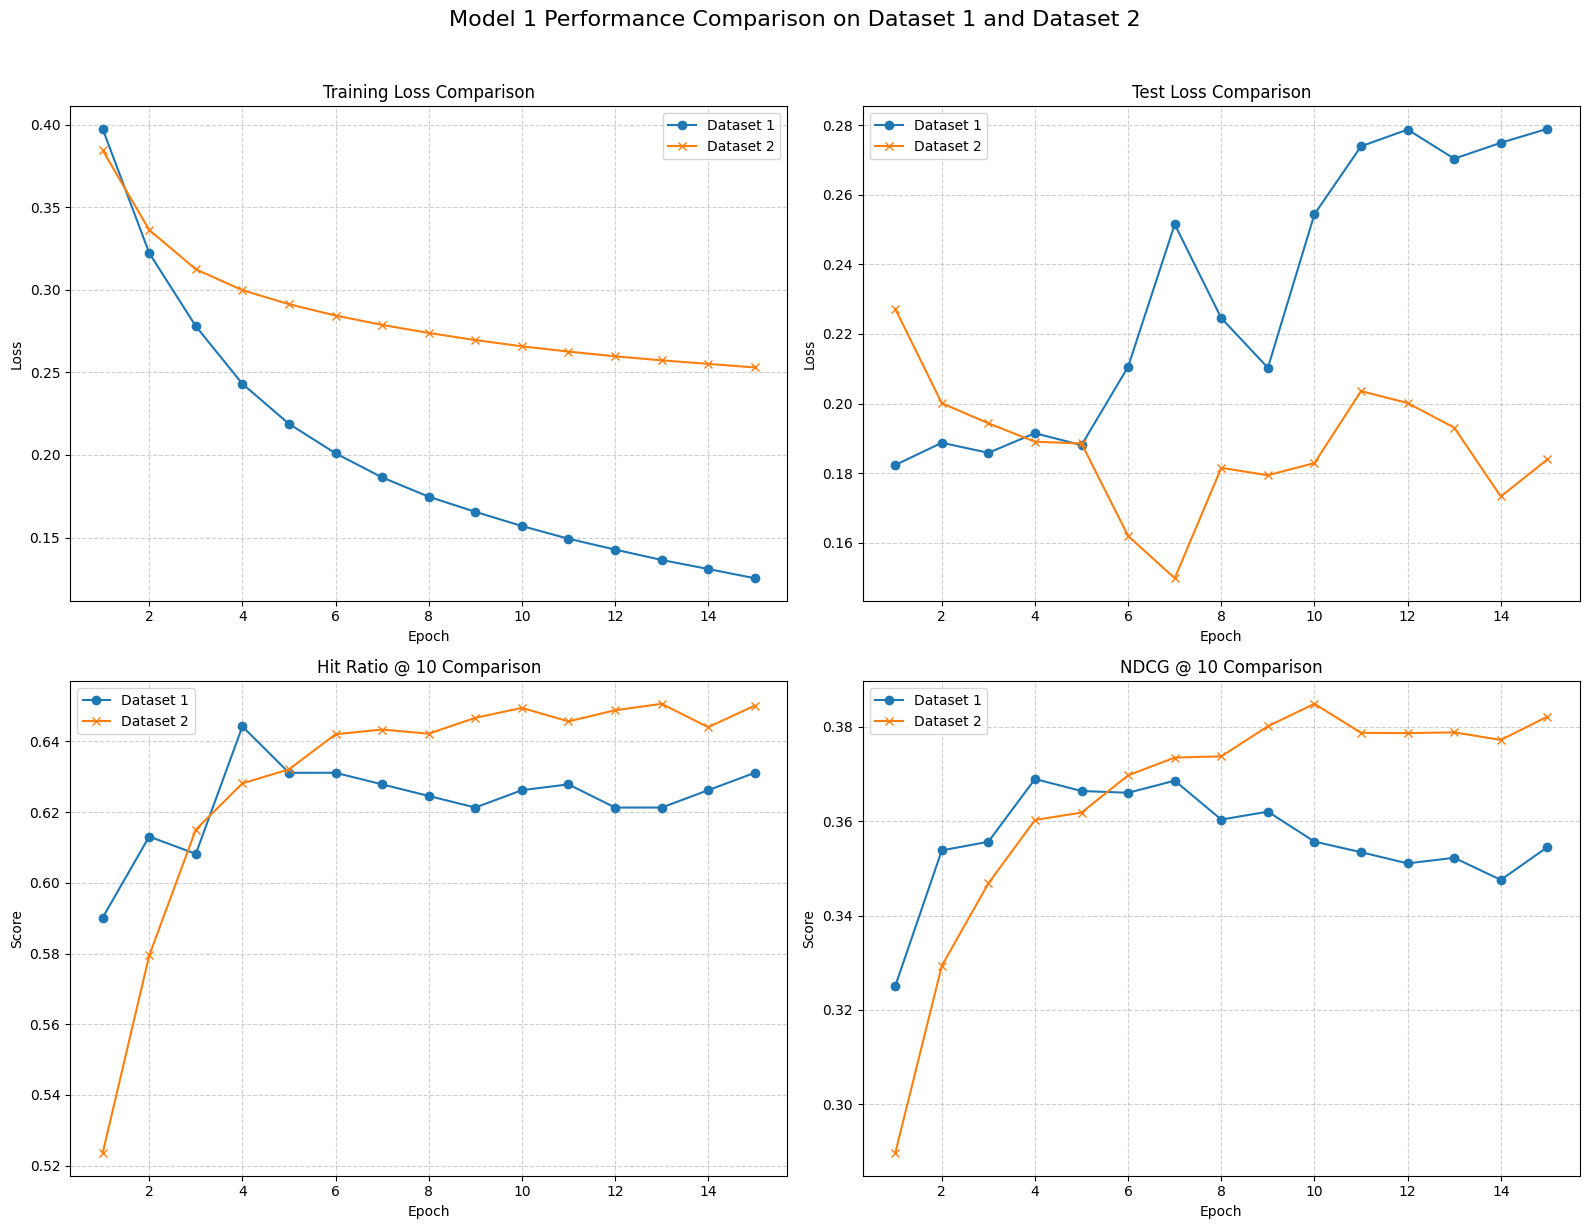

In [10]:
plot_comparison_metrics(loss_1, test_loss_list_1, hr_list_1, ndcg_list_1, loss_4, test_loss_list_4, hr_list_4, ndcg_list_4, top_k=trainer_2.top_k)

In [11]:
model

MLP(
  (user_embedding): Embedding(6041, 32)
  (item_embedding): Embedding(193610, 32)
  (mlp_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

<h2>Inference Checking</h2>

<h3>Getting inference with corresponding metrics from a test set</h3>

In [12]:
def metrics_with_recommendations_with_titles(model, test_loader, top_k, total_dataframe, device):
    """
    Function to return recommendations with metrics and predicted scores.

    Parameters:
    -----------
    model: The trained model checkpoints
    test_loader: The test data loader
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    device: According to availability CPU or a GPU

    Returns:
    ---------
    HR: The Hit rate metrics
    NDCG: The NDCG metrics
    all_recommendations: The top_k recommended movies with titles and predicted scores
    """
    HR, NDCG, all_recommendations = [], [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        # Get top-k predictions and their indices
        top_k_scores, top_k_indices = torch.topk(predictions, top_k)

        # Convert to lists
        recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
        recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

        # Ground truth item
        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

        # Get movie titles and scores for the recommended movies
        recommended_movies = []
        for rec, score in zip(recommends, recommend_scores):
            title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
            recommended_movies.append({
                'movieId': rec,
                'title': title,
                'score': float(score)  # Convert numpy float to Python float for JSON compatibility
            })

        all_recommendations.append({
            'user': user[0].item() if user.numel() == 1 else user.tolist()[0],  # Ensure single user per batch
            'ground_truth': {
                'movieId': gt_item,
                'title': total_dataframe[total_dataframe['movieId'] == gt_item]['title'].values[0]
            },
            'recommendations': recommended_movies
        })

    return np.mean(HR), np.mean(NDCG), all_recommendations

# main HERE
k = 10 # change the value of k here

HR, NDCG, all_recommendations = metrics_with_recommendations_with_titles(
    model, 
    test_loader=dataloader_test_1, 
    top_k=k,
    total_dataframe=total_df_1, 
    device=device
)

# Print metrics
print(f"Evaluation Metrics:")
print(f"HR@{k}: {HR:.3f}")
print(f"NDCG@{k}: {NDCG:.3f}")

# Print recommendations with scores (for the first user)
first_user_rec = all_recommendations[0]
print(f"\nUser: {first_user_rec['user']}")
print(f"Ground Truth: {first_user_rec['ground_truth']['title']} (MovieID: {first_user_rec['ground_truth']['movieId']})")
print(f"\nTop {k} Recommendations for User {first_user_rec['user']}:") # attention HERE
for idx, rec in enumerate(first_user_rec['recommendations'], 1):
    print(f"{idx}. {rec['title']} (MovieID: {rec['movieId']}, Score: {rec['score']:.3f})")

Evaluation Metrics:
HR@10: 0.631
NDCG@10: 0.355

User: 31
Ground Truth: Pallbearer, The (1996) (MovieID: 612)

Top 10 Recommendations for User 31:
1. Scarface (1983) (MovieID: 4262, Score: 0.897)
2. National Lampoon's Van Wilder (2002) (MovieID: 5283, Score: 0.806)
3. Ed Wood (1994) (MovieID: 235, Score: 0.679)
4. Lightning Jack (1994) (MovieID: 487, Score: 0.586)
5. Wag the Dog (1997) (MovieID: 1747, Score: 0.348)
6. Pinocchio (1940) (MovieID: 596, Score: 0.317)
7. Pallbearer, The (1996) (MovieID: 612, Score: 0.262)
8. 'burbs, The (1989) (MovieID: 2072, Score: 0.262)
9. Eaten Alive (1977) (MovieID: 3294, Score: 0.262)
10. Boot, Das (Boat, The) (1981) (MovieID: 1233, Score: 0.262)


In [13]:
def metrics_with_recommendations_with_titles(model, test_loader, top_k, total_dataframe, device):
    """
    Function to return recommendations with metrics and predicted scores.

    Parameters:
    -----------
    model: The trained model checkpoints
    test_loader: The test data loader
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    device: According to availability CPU or a GPU

    Returns:
    ---------
    HR: The Hit rate metrics
    NDCG: The NDCG metrics
    all_recommendations: The top_k recommended movies with titles and predicted scores
    """
    HR, NDCG, all_recommendations = [], [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        # Get top-k predictions and their indices
        top_k_scores, top_k_indices = torch.topk(predictions, top_k)

        # Convert to lists
        recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
        recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

        # Ground truth item
        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

        # Get movie titles and scores for the recommended movies
        recommended_movies = []
        for rec, score in zip(recommends, recommend_scores):
            title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
            recommended_movies.append({
                'movieId': rec,
                'title': title,
                'score': float(score)  # Convert numpy float to Python float for JSON compatibility
            })

        all_recommendations.append({
            'user': user[0].item() if user.numel() == 1 else user.tolist()[0],  # Ensure single user per batch
            'ground_truth': {
                'movieId': gt_item,
                'title': total_dataframe[total_dataframe['movieId'] == gt_item]['title'].values[0]
            },
            'recommendations': recommended_movies
        })

    return np.mean(HR), np.mean(NDCG), all_recommendations

# main HERE
k = 10 # change the value of k here
HR, NDCG, all_recommendations = metrics_with_recommendations_with_titles(
    model, 
    test_loader=dataloader_test_4, 
    top_k=k, 
    total_dataframe=total_df_4, 
    device=device
)

print(f"Evaluation Metrics:")
print(f"HR@{k}: {HR:.3f}")
print(f"NDCG@{k}: {NDCG:.3f}")

# Print recommendations with scores (for the first user)
first_user_rec = all_recommendations[0]
print(f"\nUser: {first_user_rec['user']}")
print(f"Ground Truth: {first_user_rec['ground_truth']['title']} (MovieID: {first_user_rec['ground_truth']['movieId']})")
print(f"\nTop {k} Recommendations for User {first_user_rec['user']}:") # attention HERE
for idx, rec in enumerate(first_user_rec['recommendations'], 1):
    print(f"{idx}. {rec['title']} (MovieID: {rec['movieId']}, Score: {rec['score']:.3f})")

Evaluation Metrics:
HR@10: 0.469
NDCG@10: 0.242

User: 891
Ground Truth: Devil's Own, The (1997) (MovieID: 1488)

Top 10 Recommendations for User 891:
1. Fargo (1996) (MovieID: 608, Score: 0.996)
2. Sword in the Stone, The (1963) (MovieID: 1025, Score: 0.917)
3. Robin Hood (1973) (MovieID: 3034, Score: 0.846)
4. Star Trek: First Contact (1996) (MovieID: 1356, Score: 0.845)
5. Vertigo (1958) (MovieID: 903, Score: 0.813)
6. Firm, The (1993) (MovieID: 454, Score: 0.765)
7. Trainspotting (1996) (MovieID: 778, Score: 0.761)
8. Spring Fever USA (a.k.a. Lauderdale) (1989) (MovieID: 3123, Score: 0.731)
9. Boogie Nights (1997) (MovieID: 1673, Score: 0.684)
10. Breakfast at Tiffany's (1961) (MovieID: 902, Score: 0.677)


<h3>Getting recommendations for an existing user of the system</h3>

In [14]:
def inference_for_single_user_by_id(model, user_id, top_k, total_dataframe, test_loader, device):
    """
    Function to perform inference for a single user by user ID and return recommendations with metrics.

    Parameters:
    -----------
    model: The trained model checkpoints
    user_id: The ID of the user for whom to make recommendations
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    test_loader: The DataLoader for the test set
    device: According to availability CPU or a GPU

    Returns:
    ---------
    recommendations: Dictionary with user ID, ground truth, and recommended movies with scores
    """
    user_found = False
    
    for user, item, label in test_loader:
        if user[0].item() == user_id:
            user_found = True
            user = user.to(device)
            item = item.to(device)

            print(f"User ID {user_id} found in the test loader.")
            predictions = model(user, item)
            top_k_scores, top_k_indices = torch.topk(predictions, top_k)

            # Convert to lists
            recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
            recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

            # Get movie details for the recommended movies
            recommended_movies = []
            for rec, score in zip(recommends, recommend_scores):
                title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
                recommended_movies.append({
                    'movieId': rec,
                    'title': title,
                    'score': float(score)  # Convert numpy float to Python float
                })

            return {
                'user': user[0].item(),
                'recommendations': recommended_movies
            }
    
    if not user_found:
        raise ValueError(f"User ID {user_id} not found in the test loader.")

# Example usage
user_id_to_infer = 1  # Replace with the user ID you want to infer
recommendations = inference_for_single_user_by_id(
    model, 
    user_id_to_infer, 
    top_k=10, 
    total_dataframe=total_df_1, 
    test_loader=dataloader_test_1, 
    device=device
)

# Print recommendations with scores
print(f"\nTop {len(recommendations['recommendations'])} Recommendations for User {recommendations['user']}:")
for idx, rec in enumerate(recommendations['recommendations'], 1):
    print(f"{idx}. {rec['title']} (ID: {rec['movieId']}) | Score: {rec['score']:.3f}")

User ID 1 found in the test loader.

Top 10 Recommendations for User 1:
1. Goofy Movie, A (1995) (ID: 239) | Score: 0.986
2. Addams Family Values (1993) (ID: 410) | Score: 0.985
3. Dracula (Bram Stoker's Dracula) (1992) (ID: 1339) | Score: 0.979
4. George of the Jungle (1997) (ID: 1588) | Score: 0.972
5. Rocky IV (1985) (ID: 2411) | Score: 0.968
6. Adventures of Priscilla, Queen of the Desert, The (1994) (ID: 345) | Score: 0.885
7. Rounders (1998) (ID: 2231) | Score: 0.863
8. Bowfinger (1999) (ID: 2770) | Score: 0.828
9. Sphere (1998) (ID: 1779) | Score: 0.750
10. Wyatt Earp (1994) (ID: 383) | Score: 0.407


In [15]:
def inference_for_single_user_by_id(model, user_id, top_k, total_dataframe, test_loader, device):
    """
    Function to perform inference for a single user by user ID and return recommendations with metrics.

    Parameters:
    -----------
    model: The trained model checkpoints
    user_id: The ID of the user for whom to make recommendations
    top_k: Total numbers of movies to recommend
    total_dataframe: The total dataframe to map the id of the movie with title
    test_loader: The DataLoader for the test set
    device: According to availability CPU or a GPU

    Returns:
    ---------
    recommendations: Dictionary with user ID, ground truth, and recommended movies with scores
    """
    user_found = False
    
    for user, item, label in test_loader:
        if user[0].item() == user_id:
            user_found = True
            user = user.to(device)
            item = item.to(device)

            print(f"User ID {user_id} found in the test loader.")
            predictions = model(user, item)
            top_k_scores, top_k_indices = torch.topk(predictions, top_k)

            # Convert to lists
            recommends = torch.take(item, top_k_indices).cpu().numpy().tolist()
            recommend_scores = top_k_scores.cpu().detach().numpy().tolist()

            # Get movie details for the recommended movies
            recommended_movies = []
            for rec, score in zip(recommends, recommend_scores):
                title = total_dataframe[total_dataframe['movieId'] == rec]['title'].values[0]
                recommended_movies.append({
                    'movieId': rec,
                    'title': title,
                    'score': float(score)  # Convert numpy float to Python float
                })

            return {
                'user': user[0].item(),
                'recommendations': recommended_movies
            }
    
    if not user_found:
        raise ValueError(f"User ID {user_id} not found in the test loader.")

# Example usage
user_id_to_infer = 1  # Replace with the user ID you want to infer
recommendations = inference_for_single_user_by_id(
    model, 
    user_id_to_infer, 
    top_k=10, 
    total_dataframe=total_df_4, 
    test_loader=dataloader_test_4, 
    device=device
)

# Print recommendations with scores
print(f"\nTop {len(recommendations['recommendations'])} Recommendations for User {recommendations['user']}:")
for idx, rec in enumerate(recommendations['recommendations'], 1):
    print(f"{idx}. {rec['title']} (ID: {rec['movieId']}) | Score: {rec['score']:.3f}")

User ID 1 found in the test loader.

Top 10 Recommendations for User 1:
1. Eraser (1996) (ID: 786) | Score: 0.999
2. Batman Forever (1995) (ID: 153) | Score: 0.996
3. Cocoon (1985) (ID: 2407) | Score: 0.993
4. Sgt. Bilko (1996) (ID: 637) | Score: 0.993
5. Better Off Dead... (1985) (ID: 1257) | Score: 0.983
6. Blair Witch Project, The (1999) (ID: 2710) | Score: 0.971
7. Weekend at Bernie's (1989) (ID: 1091) | Score: 0.964
8. Half Baked (1998) (ID: 1753) | Score: 0.959
9. City Slickers II: The Legend of Curly's Gold (1994) (ID: 432) | Score: 0.956
10. Fly Away Home (1996) (ID: 986) | Score: 0.949


In [16]:
import pandas as pd
import torch

# Initialize a list to store all batches
all_batches = []

# Iterate through the DataLoader
for batch in dataloader_test_1:  # Replace with your DataLoader
    users, items, labels = batch
    batch_data = {
        'user_id': users.numpy(),  # Convert tensors to numpy arrays
        'item_id': items.numpy(),
        'label': labels.numpy()
    }
    all_batches.append(batch_data)

# Combine all batches into a single DataFrame
df = pd.DataFrame({
    'user_id': np.concatenate([batch['user_id'] for batch in all_batches]),
    'item_id': np.concatenate([batch['item_id'] for batch in all_batches]),
    'label': np.concatenate([batch['label'] for batch in all_batches])
})

print(df)

# Save to CSV
csv_path = './Datasets/dataloader_test_D1_M1.csv'
df.to_csv(csv_path, index=False)
print(f"\nData saved to: {csv_path}")

       user_id  item_id  label
0           31      612    1.0
1           31    48774    0.0
2           31    69953    0.0
3           31     6774    0.0
4           31    33558    0.0
...        ...      ...    ...
60995       27     4361    0.0
60996       27     6013    0.0
60997       27     4459    0.0
60998       27     7345    0.0
60999       27    88515    0.0

[61000 rows x 3 columns]

Data saved to: ./Datasets/dataloader_test_D1_M1.csv


In [17]:
import pandas as pd
import torch

# Initialize a list to store all batches
all_batches = []

# Iterate through the DataLoader
for batch in dataloader_test_4:  # Replace with your DataLoader
    users, items, labels = batch
    batch_data = {
        'user_id': users.numpy(),  # Convert tensors to numpy arrays
        'item_id': items.numpy(),
        'label': labels.numpy()
    }
    all_batches.append(batch_data)

# Combine all batches into a single DataFrame
df = pd.DataFrame({
    'user_id': np.concatenate([batch['user_id'] for batch in all_batches]),
    'item_id': np.concatenate([batch['item_id'] for batch in all_batches]),
    'label': np.concatenate([batch['label'] for batch in all_batches])
})

print(df)

# Save to CSV
csv_path = './Datasets/dataloader_test_D2_M1.csv'
df.to_csv(csv_path, index=False)
print(f"\nData saved to: {csv_path}")

        user_id  item_id  label
0           891     1488    1.0
1           891     2961    0.0
2           891     3424    0.0
3           891     1474    0.0
4           891      902    0.0
...         ...      ...    ...
603995     2023     3790    0.0
603996     2023      373    0.0
603997     2023     2123    0.0
603998     2023     1038    0.0
603999     2023     1356    0.0

[604000 rows x 3 columns]

Data saved to: ./Datasets/dataloader_test_D2_M1.csv


<h2>Save Model</h2>

In [18]:
# Save model + minimal metadata
deployment_checkpoint = {
    'model_state_dict': model.state_dict(),  # Weights
    'model_hyperparams': {                  # Architecture config
        'num_users': max_num_users_global,
        'num_items': max_num_items_global,
        'embedding_size': 32,
        'layer_dims': [64, 32, 16],
        'use_NeuMF': False
    }
}

In [19]:
deployment_checkpoint

{'model_state_dict': OrderedDict([('user_embedding.weight',
               tensor([[ 1.3773e-02, -1.4636e-02, -5.9528e-03,  ...,  9.2487e-03,
                         2.1891e-03,  2.5006e-03],
                       [-1.5009e+00, -3.6257e+00,  1.5096e+00,  ..., -3.2291e+00,
                        -3.1750e-01, -1.8425e+00],
                       [-1.6044e+00, -2.0462e+00,  3.3445e+00,  ...,  5.6716e+00,
                        -1.4683e+00,  4.5492e+00],
                       ...,
                       [ 2.1660e+00,  3.7568e-01,  1.8357e+00,  ..., -5.8125e+00,
                        -9.6208e-01,  2.5302e+00],
                       [-1.0104e+00,  2.7517e+00, -4.0751e+00,  ..., -3.3321e+00,
                        -1.1749e+00,  1.4503e+00],
                       [ 1.5746e+00,  5.7216e-01, -5.9104e-01,  ..., -3.0657e+00,
                        -5.4826e+00,  4.0748e+00]])),
              ('item_embedding.weight',
               tensor([[ 9.7387e-03, -2.0052e-03, -5.9385e-03,  ..., -1

In [20]:
torch.save(deployment_checkpoint, './ncf_models/deployment_model_M1.pth')